In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

In [3]:
%load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [5]:
import mlflow
mlflow.tensorflow.autolog()

### Load data

In [6]:
data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis/')

In [7]:
data = pd.read_csv(
    data_dir / 'prd_merged_015H_20200215T0300Z_20200217T0900Z.csv',
    index_col=0)

In [8]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction',] #'cloud_volume_fraction_in_atmosphere_layer']
single_lvl_features = ['cloud_area_fraction']#['air_pressure_at_sea_level', ] 

### Data pre-processing

In [9]:
# drop NaN values in the dataset
data = data.dropna()

# drop data points with zero precip in the radar data
data = data[data[target_parameter]>0]

In [10]:
# Get a list of columns names for profile features
prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

features = data[prof_feature_columns + single_lvl_features]

target = data[[target_parameter]]

In [11]:
# data_control uses only the control member

# data_control = data[data['realization']==0]

# # Get a list of columns names for profile features
# prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

# features = data_control[prof_feature_columns + single_lvl_features]

# target = data_control[[target_parameter]]

In [12]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,281.403148,2.469136,271.8125,279.8750,281.6250,283.2500,288.1250
air_temperature_10.0,153522.0,281.434214,2.473669,271.8750,279.9375,281.6250,283.3125,288.1875
air_temperature_20.0,153522.0,281.495603,2.488522,272.0000,280.0000,281.6250,283.3750,288.3750
air_temperature_30.0,153522.0,281.431163,2.492926,271.9375,279.8750,281.5625,283.3125,288.3125
air_temperature_50.0,153522.0,281.298198,2.511828,271.7500,279.7500,281.3750,283.2500,288.1250
...,...,...,...,...,...,...,...,...
wind_speed_4500.0,153522.0,37.657170,12.339683,3.1250,28.8750,34.8125,47.0000,75.6875
wind_speed_5000.0,153522.0,39.586190,14.128948,0.6875,29.2500,36.4375,50.6250,81.5625
wind_speed_5500.0,153522.0,41.712306,15.772187,1.1250,29.7500,38.7500,54.8125,86.0000
wind_speed_6000.0,153522.0,43.893928,17.311584,0.8125,30.3750,41.2500,58.6250,89.1250


In [13]:
standardScaler = StandardScaler()

features = pd.DataFrame(standardScaler.fit_transform(features), 
                                columns=features.columns,
                                index=features.index)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,-5.017796e-15,1.000003,-3.884224,-0.618902,0.089850,0.747977,2.722358
air_temperature_10.0,153522.0,-1.889819e-15,1.000003,-3.864399,-0.605060,0.077127,0.759314,2.730077
air_temperature_20.0,153522.0,8.673026e-15,1.000003,-3.815772,-0.601002,0.051998,0.755228,2.764459
air_temperature_30.0,153522.0,-9.964501e-15,1.000003,-3.808254,-0.624234,0.052684,0.754673,2.760355
air_temperature_50.0,153522.0,2.849539e-15,1.000003,-3.801307,-0.616365,0.030576,0.777047,2.717871
...,...,...,...,...,...,...,...,...
wind_speed_4500.0,153522.0,-4.739358e-17,1.000003,-2.798474,-0.711704,-0.230531,0.757139,3.081964
wind_speed_5000.0,153522.0,-2.369679e-17,1.000003,-2.753129,-0.731564,-0.222855,0.781293,2.970953
wind_speed_5500.0,153522.0,-5.924198e-18,1.000003,-2.573355,-0.758446,-0.187819,0.830591,2.807971
wind_speed_6000.0,153522.0,8.293877e-17,1.000003,-2.488598,-0.780921,-0.152726,0.850940,2.612772


In [14]:
processed_data = pd.concat([features, target], axis=1, sort=False)
processed_data

,air_temperature_5.0,air_temperature_10.0,air_temperature_20.0,air_temperature_30.0,air_temperature_50.0,air_temperature_75.0,air_temperature_100.0,air_temperature_150.0,air_temperature_200.0,air_temperature_250.0,...,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0,cloud_area_fraction,rainfall_rate_composite
0,0.950478,0.936178,0.905921,0.905099,0.926341,0.964120,0.998305,1.081785,1.155757,1.206579,...,-0.395362,-0.411690,-0.459169,-0.511568,-0.569884,-0.435185,-0.584087,-0.690663,0.481991,0.004584
1,0.899853,0.885645,0.855690,0.854957,0.876576,0.889926,0.900185,0.960767,1.036554,1.112492,...,-0.582185,-0.631873,-0.595090,-0.564688,-0.681314,-0.598857,-0.520684,-0.542640,0.481991,0.004584
2,1.152978,1.138307,1.106844,1.105667,1.075635,1.137240,1.194545,1.251211,1.298800,1.347711,...,-0.543264,-0.539538,-0.504476,-0.499764,-0.493910,-0.183043,-0.318588,-0.596795,0.481991,0.004584
3,1.203604,1.188839,1.157075,1.155809,1.175165,1.186702,1.194545,1.251211,1.274959,1.300667,...,-0.558832,-0.603462,-0.633925,-0.653222,-0.595209,-0.359985,-0.485020,-0.625677,0.481991,0.004584
4,0.798602,0.784580,0.755228,0.754673,0.777047,0.791000,0.802065,0.863952,0.893512,0.900795,...,-0.496558,-0.525333,-0.523893,-0.517470,-0.529365,-0.364408,-0.500871,-0.614846,0.481991,0.004584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211387,-0.542964,-0.554528,-0.601002,-0.599163,-0.616365,-0.618689,-0.620674,-0.636677,-0.632279,-0.651651,...,-0.060636,-0.056556,-0.096713,-0.169237,-0.255856,-0.306902,-0.393879,-0.481265,0.425977,0.040529
211388,-0.087338,-0.099736,-0.098695,-0.097742,-0.118718,-0.124061,-0.130074,-0.152603,-0.203150,-0.228257,...,0.040560,0.135216,0.116876,-0.003974,-0.124167,-0.169772,-0.259147,-0.329632,0.257936,0.040529
211389,-0.264526,-0.276600,-0.299618,-0.298310,-0.317777,-0.321912,-0.326314,-0.346233,-0.346193,-0.369388,...,-0.021715,-0.070762,-0.129076,-0.198748,-0.321701,-0.426338,-0.500871,-0.542640,-1.366463,0.040529
211390,-0.163276,-0.175535,-0.199156,-0.223097,-0.243130,-0.272449,-0.277254,-0.297825,-0.298512,-0.322345,...,-0.340872,-0.340663,-0.303831,-0.240064,-0.265986,-0.390950,-0.488983,-0.557081,0.481991,0.040529


### Split the dataset into 60/20/20 subsets for training, testing and validation

In [15]:
# Height profiles data
X_train_prof, X_test_prof, y_train, y_test = train_test_split(
    features[prof_feature_columns],
    target,
    test_size=0.2,
    random_state=1
)

X_train_prof, X_val_prof, y_train, y_test = train_test_split(
    X_train_prof,
    y_train,
    test_size=0.25,
    random_state=1
)

# Single level data
X_train_singlvl, X_test_singlvl, y_train, val = train_test_split(
    features[single_lvl_features],
    target,
    test_size=0.2,
    random_state=1
)

X_train_singlvl, X_val_singlvl, y_train, y_val = train_test_split(
    X_train_singlvl,
    y_train,
    test_size=0.25,
    random_state=1
)

# y_train, y_val and y_test are the same for both profile and single level data if the random state is set

In [16]:
# reshape height profile variables 
X_train_prof = np.transpose(X_train_prof.to_numpy().reshape(X_train_prof.shape[0], len(profile_features), 33), (0, 2, 1))
X_val_prof = np.transpose(X_val_prof.to_numpy().reshape(X_val_prof.shape[0], len(profile_features), 33), (0, 2, 1))
X_test_prof = np.transpose(X_test_prof.to_numpy().reshape(X_test_prof.shape[0], len(profile_features), 33), (0, 2, 1))

### Build model

In [17]:
def build_model(nprof_features, nheights, nsinglvl_features):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features
        
        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, use_bias=False, activation='relu')(x)
        x = Dense(1024, use_bias=False, activation='relu')(x)
        
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    
    else:
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(out)
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

In [18]:
nprof_features = len(profile_features)
nheights = len(prof_feature_columns)//len(profile_features)
nsinglvl_features = len(single_lvl_features)

In [19]:
# mlflow.create_experiment('prd_exp1')

In [20]:
exp1 = mlflow.get_experiment('1')

In [21]:
if nsinglvl_features > 0:
    X_train = [X_train_prof, X_train_singlvl]
    X_val = [X_val_prof, X_val_singlvl]
    X_test = [X_test_prof, X_test_singlvl]
else:
    X_train = X_train_prof
    X_val = X_val_prof
    X_test = X_test_prof

In [22]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [23]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# run tensorboard --logdir LOGDIRPATH from command line to launch 

In [24]:
from keras import backend as K
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [25]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    model = build_model(nprof_features, nheights, nsinglvl_features)
    # model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = 'mean_absolute_error'
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), coeff_determination]
    )
    mlflow.log_param('input features', ', '.join((profile_features + single_lvl_features)))
    history = model.fit(X_train, y_train, epochs=2, batch_size=100, validation_data=(X_val, y_val), verbose=1, callbacks=[tensorflow_callback])    

2022-04-14 15:36:59.706213: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/2
922/922 [==============================] - 17s 18ms/step - loss: 1.0395 - root_mean_squared_error: 1.7660 - mean_absolute_error: 1.0395 - coeff_determination: 0.5288 - val_loss: 0.9437 - val_root_mean_squared_error: 1.6119 - val_mean_absolute_error: 0.9437 - val_coeff_determination: 0.6031
Epoch 2/2
  4/922 [..............................] - ETA: 22s - loss: 0.9453 - root_mean_squared_error: 1.5749 - mean_absolute_error: 0.9453 - coeff_determination: 0.6764

2022-04-14 15:37:17.575650: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125829120 exceeds 10% of free system memory.


922/922 [==============================] - 17s 18ms/step - loss: 0.9108 - root_mean_squared_error: 1.5560 - mean_absolute_error: 0.9108 - coeff_determination: 0.6313 - val_loss: 0.8962 - val_root_mean_squared_error: 1.5844 - val_mean_absolute_error: 0.8962 - val_coeff_determination: 0.6162


2022-04-14 15:37:34.277222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125829120 exceeds 10% of free system memory.
2022-04-14 15:37:34.806736: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/tmp/tmpy_geil7t/model/data/model/assets


/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
2022/04/14 15:37:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/tmp/tmpy_geil7t/model, flavor: keras), fall back to return ['tensorflow==2.7.0', 'keras==2.7.0']. Set logging level to DEBUG to see the full traceback.


## Feature importance - permutation importance

In [26]:
feature_names = profile_features + single_lvl_features
feature_names

['air_temperature',
 'relative_humidity',
 'wind_speed',
 'wind_from_direction',
 'cloud_area_fraction']

In [3]:
# visualise filters
from matplotlib import pyplot
# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, i]
    ax = pyplot.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(f, cmap='gray')
    ix += 1
# show the figure
pyplot.show()

### Permutation importance - Breiman
 - At each step, only one predictor is permuted (randomized)
 - The amount by which the cost function increases when 𝑥 is randomized, is considered the importance of 𝑥
 - If the cost function increases slightly when 𝑥 is permuted, 𝑥 is somewhat important
 - If the cost function explodes when 𝑥 is permuted, 𝑥 is very important
 - If the cost function remains the same or decreases when 𝑥 is permuted, 𝑥 is not important

In [27]:
original_mae = history.history['val_mean_absolute_error'][-1]

In [28]:
# permute by shuffling data
permutation_importance = {key:[] for key in feature_names}
npermutations = 4

for ifeature, feature in enumerate(feature_names):
    print(f'permuting feature: {feature}')
    for iperm in np.arange(npermutations):
        print(f'permutation number: {iperm}')

        if nsinglvl_features > 0:
            X_val_permute = [X_val[0].copy(), X_val[1].copy()]
            if feature in single_lvl_features:
                X_val_permute[1][feature] = X_val_permute[1][feature].reindex(
                    np.random.permutation(X_val_permute[1][feature].index)).values
            else:
                X_val_permute[0][..., ifeature] = np.take(
                    X_val_permute[0][..., ifeature],
                    indices=np.random.permutation(X_val_permute[0].shape[0]),
                    axis=0)
                
        else:
            X_val_permute = X_val.copy()
            X_val_permute[..., ifeature] = np.take(
                X_val_permute[..., ifeature],
                indices=np.random.permutation(X_val_permute.shape[0]),
                axis=0)

        y_pred = model.predict(X_val_permute)
        permuted_mae = metrics.mean_absolute_error(y_val, y_pred)
        permutation_importance[feature].append(permuted_mae - original_mae)

permuting feature: air_temperature
permutation number: 0
permutation number: 1
permutation number: 2
permutation number: 3
permuting feature: relative_humidity
permutation number: 0
permutation number: 1
permutation number: 2
permutation number: 3
permuting feature: wind_speed
permutation number: 0
permutation number: 1
permutation number: 2
permutation number: 3
permuting feature: wind_from_direction
permutation number: 0
permutation number: 1
permutation number: 2
permutation number: 3
permuting feature: cloud_area_fraction
permutation number: 0
permutation number: 1
permutation number: 2
permutation number: 3


In [29]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.7140406277099253, 'relative_humidity': 0.6333158391676535, 'wind_speed': 0.4499770351903158, 'wind_from_direction': 0.7379838317681702, 'cloud_area_fraction': 0.002447417150562403}


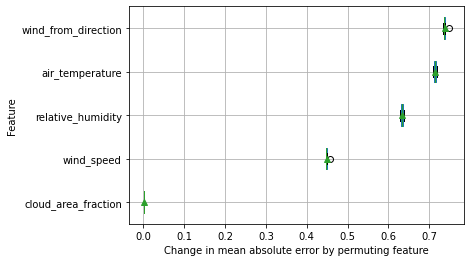

In [30]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in mean absolute error by permuting feature')
plt.show()

### Permutation importance - Lakshmanan
 - In first round of Lakshmanan test, only one predictor is randomized at each step.
 - Thus, first round of Lakshmanan test = all of Breiman test.
 - At end of first round, the most important predictor (𝑥1) is permanently randomized.
 - In second round of Lakshmanan test, two predictors (𝑥1 and another) are randomized at each step.
 - At end of second round, the second-most important predictor (𝑥2) is permanently randomized.
 - Keeps going until all predictors are randomized.
 
<b>Currently doesn't work if single level features are included</b>

In [32]:
# predictor_names = feature_names.copy()
remaining_feature_names = feature_names.copy()
current_step_num = 0

permuted_feature_name_by_step = []
highest_metric_by_step = []

In [33]:
X_val_copy = X_val.copy()
while len(remaining_feature_names) > 0:
    current_step_num += 1

    highest_metric = -np.inf
    most_important_feature = None
    best_predictor_permuted_values = None

    for feature in remaining_feature_names:
        print(f'permuting feature "{feature}" at step {current_step_num}')
        feature_idx = feature_names.index(feature)
        print(feature_idx)
        X_val_permuted = X_val.copy()

        X_val_permuted[..., feature_idx] = np.take(
            X_val_permuted[..., feature_idx],
            indices=np.random.permutation(X_val_permuted.shape[0]), 
            axis=0)

        y_pred = model.predict(X_val_permuted)

        metric = metrics.mean_absolute_error(y_val, y_pred)
        print('Mean absolute error with permuted feature = {0:.4e}'.format(metric))

        if metric < highest_metric:
            continue

        highest_metric = metric
        most_important_feature = feature
        most_important_feature_permuted_values = X_val_permuted[..., feature_idx]

    permuted_feature_name_by_step.append(most_important_feature)
    highest_metric_by_step.append(highest_metric - original_mae)

    # Remove best predictor from list.
    remaining_feature_names.remove(most_important_feature)

    # Leave values of best predictor permuted.
    feature_idx = feature_names.index(most_important_feature)
    X_val_copy[..., feature_idx] = most_important_feature_permuted_values

    print('\nBest predictor = "{0:s}" ... new cost = {1:.4e}\n'.format(
        most_important_feature, highest_metric
    ))

permuting feature "air_temperature" at step 1
0


TypeError: list indices must be integers or slices, not tuple

In [ ]:
result_dict = {
        'feature_importance_order': permuted_feature_name_by_step, 
        'highest_mae_by_step': np.array(highest_metric_by_step), # The highest mean absolute error is how the most important feature is selected
        'original_mae': original_mae,
    }

In [ ]:
result_dict

In [ ]:
x_coords = np.concatenate((
        np.array([result_dict['original_mae']]),
        result_dict['highest_mae_by_step']
    ))

y_strings = ['No permutation'] + result_dict['feature_importance_order']
y_coords = np.linspace(0, len(y_strings)-1, num=len(y_strings), dtype=float)[::-1]

In [ ]:
def _label_bars_in_graph(axes_object, y_coords, y_strings):
    """Labels bars in graph.

    J = number of bars

    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
        Will plot on these axes.
    :param y_coords: length-J numpy array with y-coordinates of bars.
    :param y_strings: length-J list of labels.
    """

    x_min, x_max = plt.xlim()
    x_coord_for_text = x_max - 0.01 * (x_max - x_min)

    for j in range(len(y_coords)):
        axes_object.text(
            x_coord_for_text, y_coords[j], y_strings[j], color='k',
            horizontalalignment='right', verticalalignment='center',
            fontsize='small', fontweight='bold')


In [ ]:
 _, axes_object = plt.subplots(1, 1, figsize=(10, 10))
axes_object.barh(y_coords, x_coords)
plt.yticks([], [])
plt.ylabel('Predictor permuted')
plt.xlabel('MAE (increase in)')
_label_bars_in_graph(axes_object=axes_object, y_coords=y_coords, y_strings=y_strings)
plt.show()

In [ ]:
from matplotlib import pyplot
# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, i]
    ax = pyplot.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(f, cmap='gray')
    ix += 1
# show the figure
pyplot.show()

In [ ]:
# from sklearn.inspection import permutation_importance
# r = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)
# for i in r.importances_mean.argsort()[::-1]:
#      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{(profile_features + single_lvl_features)[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [ ]:
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

# eli5.explain_prediction(model, X_test[0:1], image=True)

In [ ]:
# import shap

# # # background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
# background = X_train[np.random.choice(X_train.shape[0],100, replace=False)]

# explainer = shap.DeepExplainer(
#     (model.layers[0].input, model.layers[-1].output), background
# )

# # explainer = shap.DeepExplainer(
# #     model, background
# # )
# explainer.shap_values(X_val)

## Evaluation

In [ ]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_val, y_pred, s=50, c='darkblue', label='ML pred', alpha=0.5)
plt.scatter(y_val, data.thickness_of_rainfall_amount[y_val.index]*1000, s=50, c='orange', label='NWP pred', alpha=0.5)
plt.gca().plot([0, 30], [0, 30], ls="--", c=".3")
plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()

In [ ]:
from scipy.stats import pearsonr

In [ ]:
y_pred = np.squeeze(y_pred)

In [ ]:
y_pred.shape

In [ ]:
y_val_arr = np.squeeze(y_val.values)

In [ ]:
pearsonr(y_val_arr, y_pred)

In [ ]:
pearsonr(y_val_arr, (data.thickness_of_rainfall_amount[y_val.index]*1000).values)

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(y_val, alpha=0.5, bins=40, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
plt.legend()
plt.show()

## Control member only plots

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 8))

# plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
# plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
# plt.legend()
# plt.ylabel('MAE [mm of precipitation]')
# plt.xlabel('epochs')
# plt.title('control member only')
# plt.show()

In [ ]:
# y_pred = model.predict(X_test)

# plt.figure(figsize=(10, 8))

# plt.scatter(y_test, y_pred, s=200, c='darkblue')
# plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")

# plt.xlabel('Actual 3hr precip accumulation value')
# plt.ylabel('Predicted 3hr precip_accumulation value')
# plt.show()

In [ ]:
# from sklearn.metrics import mean_absolute_error, r2_score
# error = mean_absolute_error(y_test, y_pred)
# print(f'MAE: {error:.3f}')

# rsqrd = r2_score(y_test, y_pred)
# print(f'R-squared score: {rsqrd:.3f}')

In [ ]:
# plt.figure(figsize=(10, 8))
# plt.hist(y_test, alpha=0.5, bins=25, label='Actual')
# plt.hist(y_pred, alpha=0.5, bins=25, label='Predicted')
# plt.legend()
# plt.show()